# Base model for stock prediction

In [65]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

 2025-10-14 14:00:54 - data_repository - INFO - Loaded: AAPL
 2025-10-14 14:00:54 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-14 14:00:54 - data_repository - INFO - Loaded: IBM
 2025-10-14 14:00:54 - data_repository - INFO - Loaded: AMZN
 2025-10-14 14:00:54 - data_repository - INFO - Loaded periodic stock market data for: {'AMZN', 'IBM', 'AAPL', 'AMZN_enhanced'}


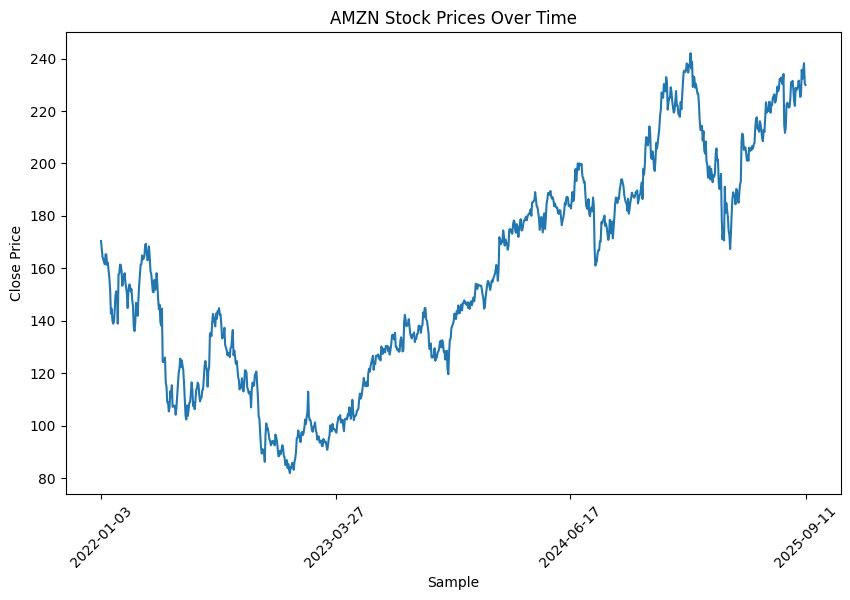

In [66]:
from core.data_repository import DataRepository
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices Over Time')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.show()

In [67]:
from core.data_preparator import DataPreparator

timesteps_lookback = 3

AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data,
    target_column='Close',
    t=timesteps_lookback
)

AMZN_supervised_data

 2025-10-14 14:00:55 - data_preparator - INFO - Preparing data for target column: Close, with t=3


,Close,Close_0,Close_1,Close_2
Date,,,,
2022-01-06,163.253998,164.356995,167.522003,170.404495
2022-01-07,162.554001,163.253998,164.356995,167.522003
2022-01-10,161.485992,162.554001,163.253998,164.356995
2022-01-11,165.362000,161.485992,162.554001,163.253998
2022-01-12,165.207001,165.362000,161.485992,162.554001
...,...,...,...,...
2025-09-05,232.330002,235.679993,225.990005,225.339996
2025-09-08,235.839996,232.330002,235.679993,225.990005
2025-09-09,238.240005,235.839996,232.330002,235.679993


In [68]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [69]:
target = 'Close'
features = [col for col in AMZN_supervised_data.columns if col != target]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(AMZN_train_dataset[features])
scaler_y.fit(AMZN_train_dataset[[target]])

X_train_scaled = scaler_X.transform(AMZN_train_dataset[features])
y_train_scaled = scaler_y.transform(AMZN_train_dataset[[target]])

X_validation_scaled = scaler_X.transform(AMZN_validation_dataset[features])
y_validation_scaled = scaler_y.transform(AMZN_validation_dataset[[target]])

X_test_scaled = scaler_X.transform(AMZN_test_dataset[features])
y_test_scaled = scaler_y.transform(AMZN_test_dataset[[target]])

AMZN_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
AMZN_train_scaled[target] = y_train_scaled

AMZN_validation_scaled = pd.DataFrame(X_validation_scaled, columns=features)
AMZN_validation_scaled[target] = y_validation_scaled

AMZN_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
AMZN_test_scaled[target] = y_test_scaled

AMZN_train_dataset = AMZN_train_scaled
AMZN_validation_dataset = AMZN_validation_scaled
AMZN_test_dataset = AMZN_test_scaled

In [70]:
display(AMZN_train_dataset.shape, AMZN_validation_dataset.shape, AMZN_test_dataset.shape)
display(AMZN_train_dataset.head(), AMZN_validation_dataset.head(), AMZN_test_dataset.head())

(664, 4)

(166, 4)

(93, 4)

,Close_0,Close_1,Close_2,Close
0,0.698401,0.725182,0.749573,0.689068
1,0.689068,0.698401,0.725182,0.683144
2,0.683144,0.689068,0.698401,0.674107
3,0.674107,0.683144,0.689068,0.706905
4,0.706905,0.674107,0.683144,0.705593


,Close_0,Close_1,Close_2,Close
0,0.752919,0.772550,0.792689,0.764089
1,0.764089,0.752919,0.772550,0.818074
2,0.818074,0.764089,0.752919,0.799035
3,0.799035,0.818074,0.764089,0.774327
4,0.774327,0.799035,0.818074,0.812913


,Close_0,Close_1,Close_2,Close
0,0.893298,0.895921,0.906837,0.868167
1,0.868167,0.893298,0.895921,0.917076
2,0.917076,0.868167,0.893298,0.915214
3,0.915214,0.917076,0.868167,0.884498
4,0.884498,0.915214,0.917076,0.873160


In [71]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-10-14 14:00:56 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 14:00:56 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 14:00:56 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [72]:
from models.lstm_model import LSTMStockModel
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss



def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 8, 128)
    layer_dim = trial.suggest_int('layer_dim', 1, 4)
    learning_rate = trial.suggest_int('learning_rate', 0.001, 0.005)
    
    AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
    
    model = LSTMStockModel(
        id='base_amzn_model',
        ticker='AMZN',
        input_dim=1,
        hidden_dim=hidden_dim,
        layer_dim=layer_dim,
        output_dim=1
    )
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_function = MSELoss()
    
    model.train()
    for epoch in range(20):
        for X,y in AMZN_train_data_loader:
            optimizer.zero_grad()
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
            outputs, _ = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
    return loss.item()
            

In [73]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print(f'Best hyperparameters: {study.best_params}')

[I 2025-10-14 14:00:56,777] A new study created in memory with name: no-name-650baaa3-7383-49a5-bb7a-41f1303df258


 2025-10-14 14:00:56 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=33,
layer_dimension=2,
output_dimension=1)


[I 2025-10-14 14:00:59,160] Trial 0 finished with value: 0.4152628481388092 and parameters: {'hidden_dim': 33, 'layer_dim': 2, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:00:59 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=90,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:02,930] Trial 1 finished with value: 0.8382652997970581 and parameters: {'hidden_dim': 90, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:02 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=37,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:05,528] Trial 2 finished with value: 0.7563786506652832 and parameters: {'hidden_dim': 37, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:05 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=56,
layer_dimension=1,
output_dimension=1)


[I 2025-10-14 14:01:06,897] Trial 3 finished with value: 0.8865641355514526 and parameters: {'hidden_dim': 56, 'layer_dim': 1, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:06 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=94,
layer_dimension=1,
output_dimension=1)


[I 2025-10-14 14:01:08,735] Trial 4 finished with value: 0.6135136485099792 and parameters: {'hidden_dim': 94, 'layer_dim': 1, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:08 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=73,
layer_dimension=2,
output_dimension=1)


[I 2025-10-14 14:01:11,128] Trial 5 finished with value: 0.5044076442718506 and parameters: {'hidden_dim': 73, 'layer_dim': 2, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:11 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=102,
layer_dimension=4,
output_dimension=1)


[I 2025-10-14 14:01:16,000] Trial 6 finished with value: 0.8121957778930664 and parameters: {'hidden_dim': 102, 'layer_dim': 4, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:16 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=37,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:18,768] Trial 7 finished with value: 0.7121980786323547 and parameters: {'hidden_dim': 37, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:18 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=109,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:23,081] Trial 8 finished with value: 0.6251264810562134 and parameters: {'hidden_dim': 109, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 0 with value: 0.4152628481388092.


 2025-10-14 14:01:23 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=44,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:25,738] Trial 9 finished with value: 0.4050976037979126 and parameters: {'hidden_dim': 44, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 9 with value: 0.4050976037979126.


 2025-10-14 14:01:25 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=10,
layer_dimension=4,
output_dimension=1)


[I 2025-10-14 14:01:29,034] Trial 10 finished with value: 0.8726577758789062 and parameters: {'hidden_dim': 10, 'layer_dim': 4, 'learning_rate': 0}. Best is trial 9 with value: 0.4050976037979126.


 2025-10-14 14:01:29 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=16,
layer_dimension=2,
output_dimension=1)


[I 2025-10-14 14:01:30,995] Trial 11 finished with value: 0.5037389397621155 and parameters: {'hidden_dim': 16, 'layer_dim': 2, 'learning_rate': 0}. Best is trial 9 with value: 0.4050976037979126.


 2025-10-14 14:01:31 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=43,
layer_dimension=2,
output_dimension=1)


[I 2025-10-14 14:01:33,347] Trial 12 finished with value: 0.5843375325202942 and parameters: {'hidden_dim': 43, 'layer_dim': 2, 'learning_rate': 0}. Best is trial 9 with value: 0.4050976037979126.


 2025-10-14 14:01:33 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=71,
layer_dimension=2,
output_dimension=1)


[I 2025-10-14 14:01:35,781] Trial 13 finished with value: 0.6678633689880371 and parameters: {'hidden_dim': 71, 'layer_dim': 2, 'learning_rate': 0}. Best is trial 9 with value: 0.4050976037979126.


 2025-10-14 14:01:35 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=27,
layer_dimension=1,
output_dimension=1)


[I 2025-10-14 14:01:37,141] Trial 14 finished with value: 0.3360116481781006 and parameters: {'hidden_dim': 27, 'layer_dim': 1, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


 2025-10-14 14:01:37 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=55,
layer_dimension=1,
output_dimension=1)


[I 2025-10-14 14:01:38,570] Trial 15 finished with value: 0.5660494565963745 and parameters: {'hidden_dim': 55, 'layer_dim': 1, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


 2025-10-14 14:01:38 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=20,
layer_dimension=4,
output_dimension=1)


[I 2025-10-14 14:01:41,836] Trial 16 finished with value: 0.43340709805488586 and parameters: {'hidden_dim': 20, 'layer_dim': 4, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


 2025-10-14 14:01:41 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=127,
layer_dimension=1,
output_dimension=1)


[I 2025-10-14 14:01:43,602] Trial 17 finished with value: 0.7107933759689331 and parameters: {'hidden_dim': 127, 'layer_dim': 1, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


 2025-10-14 14:01:43 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=54,
layer_dimension=3,
output_dimension=1)


[I 2025-10-14 14:01:46,530] Trial 18 finished with value: 0.9342963695526123 and parameters: {'hidden_dim': 54, 'layer_dim': 3, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


 2025-10-14 14:01:46 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=26,
layer_dimension=4,
output_dimension=1)


[I 2025-10-14 14:01:49,543] Trial 19 finished with value: 0.5012986660003662 and parameters: {'hidden_dim': 26, 'layer_dim': 4, 'learning_rate': 0}. Best is trial 14 with value: 0.3360116481781006.


Best hyperparameters: {'hidden_dim': 27, 'layer_dim': 1, 'learning_rate': 0}


In [83]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=27,
    layer_dim=1,
    output_dim=1
)

 2025-10-14 14:02:13 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=27,
layer_dimension=1,
output_dimension=1)


In [84]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [85]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)


train_rmse_list = []
val_rmse_list = []

predictions = []
actuals = []
epochs = 20

for epoch in range(epochs):
    # Training loop
    AMZN_base_model.train()
    train_loss = 0
    for X,y in AMZN_train_data_loader:
        optimizer.zero_grad()
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
        outputs, _ = AMZN_base_model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.detach().numpy().flatten())
        actuals.extend(y.numpy().flatten())
        
    # Validation loop
    AMZN_base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X,y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
            outputs, _ = AMZN_base_model(X)
            val_loss += loss_function(outputs, y).item()
            
    train_rmse = np.sqrt(train_loss / len(AMZN_train_data_loader))
    val_rmse = np.sqrt(val_loss / len(AMZN_validation_data_loader))
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
        
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'RMSE: {train_rmse:.4f}')
    print(f'Validation RMSE: {val_rmse:.4f}')

Epoch [1/20]
RMSE: 0.5116
Validation RMSE: 0.8511
Epoch [2/20]
RMSE: 0.2606
Validation RMSE: 0.4612
Epoch [3/20]
RMSE: 0.2708
Validation RMSE: 0.4628
Epoch [4/20]
RMSE: 0.2335
Validation RMSE: 0.4013
Epoch [5/20]
RMSE: 0.2180
Validation RMSE: 0.3560
Epoch [6/20]
RMSE: 0.1982
Validation RMSE: 0.3031
Epoch [7/20]
RMSE: 0.1760
Validation RMSE: 0.2415
Epoch [8/20]
RMSE: 0.1491
Validation RMSE: 0.1670
Epoch [9/20]
RMSE: 0.1162
Validation RMSE: 0.0861
Epoch [10/20]
RMSE: 0.0803
Validation RMSE: 0.0420
Epoch [11/20]
RMSE: 0.0520
Validation RMSE: 0.0454
Epoch [12/20]
RMSE: 0.0409
Validation RMSE: 0.0441
Epoch [13/20]
RMSE: 0.0398
Validation RMSE: 0.0431
Epoch [14/20]
RMSE: 0.0403
Validation RMSE: 0.0428
Epoch [15/20]
RMSE: 0.0408
Validation RMSE: 0.0426
Epoch [16/20]
RMSE: 0.0409
Validation RMSE: 0.0425
Epoch [17/20]
RMSE: 0.0410
Validation RMSE: 0.0426
Epoch [18/20]
RMSE: 0.0412
Validation RMSE: 0.0428
Epoch [19/20]
RMSE: 0.0414
Validation RMSE: 0.0431
Epoch [20/20]
RMSE: 0.0416
Validation RM

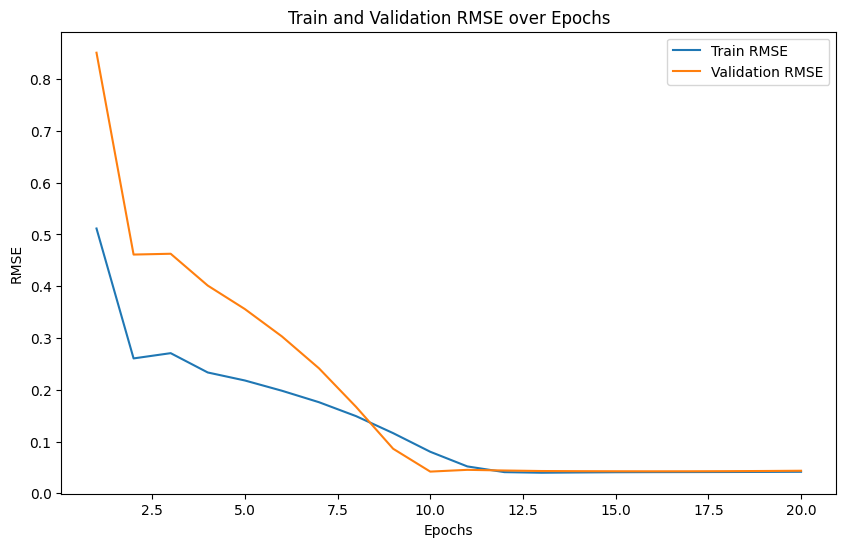

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs_range, y=train_rmse_list, label='Train RMSE')
sns.lineplot(x=epochs_range, y=val_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Epochs')
plt.legend()
plt.show()

In [88]:
AMZN_base_model.eval()
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
test_loss = 0

predictions = []
actuals = []

with torch.no_grad():
    for X,y in AMZN_test_data_loader:
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
        outputs, _ = AMZN_base_model(X)
        test_loss += loss_function(outputs, y).item()
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(y.numpy().flatten())

test_rmse = np.sqrt(test_loss / len(AMZN_test_data_loader))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 0.0406


In [89]:
import numpy as np
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

original_test_loss = np.sqrt(loss_function(torch.tensor(predictions), torch.tensor(actuals)).item())
print(f'Test Loss (RMSE) on original scale: {original_test_loss:.4f}')

errors = actuals - predictions

Test Loss (RMSE) on original scale: 4.8246


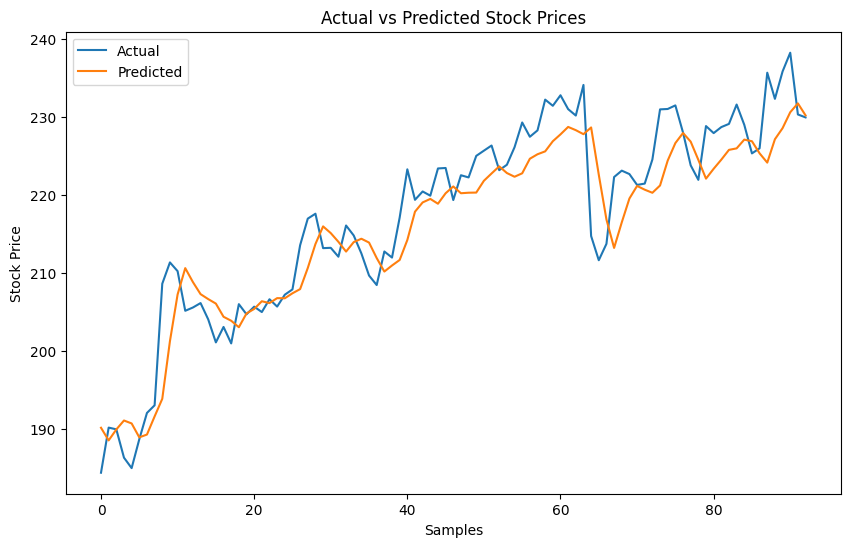

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals)), y=actuals, label='Actual')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

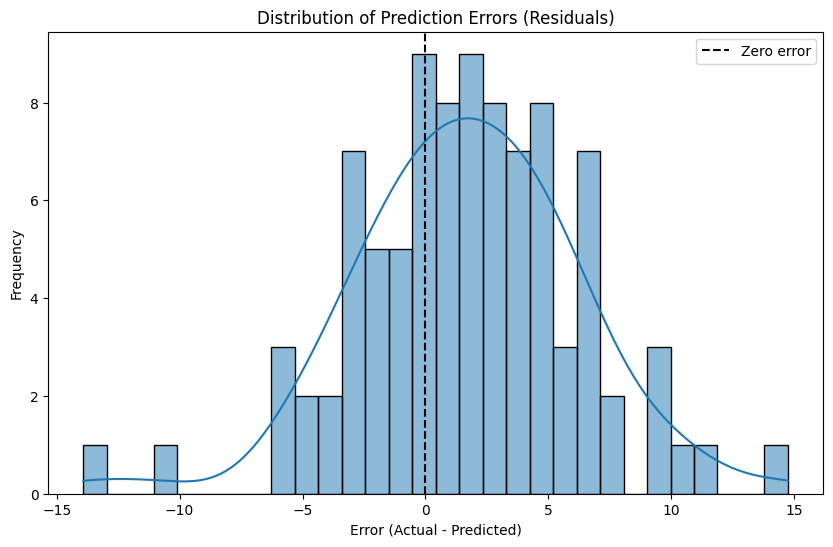

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='black', linestyle='--', label='Zero error')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()